<a href="https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/fit_mulltiple_1d_gaussians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides an example of how to fit multiple 1-d gaussians simultaneously in python as may be done in spec_fit. Code based on discussion at https://stackoverflow.com/questions/34136737/using-scipy-curve-fit-for-a-variable-number-of-parameters

Author: dmehring 12jan2022

Install casatools

In [271]:
import os
print("installing casatools (takes a minute)...")
os.system("apt-get install libgfortran3")
os.system("pip install casatools==6.3.0.48")
os.system('pip install casadata')
print('complete')

installing casatools (takes a minute)...
complete


imports

In [272]:
from casatools import functional
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

Define functions to determine rms and compute model values

In [273]:
def __rms(y: np.array) -> float:
  return np.sqrt(np.sum(y*y)/len(y))

def __model(x: np.array, g1d: list) -> np.array:
  m = np.zeros(len(x))
  for g in g1d:
    m += g.f(x)
  return m

Define chi square for curve fitting

In [274]:
def __chi_square(y: np.array, model: np.array, sigma: float) -> float:
  residual_sigma = (model - y)/sigma
  return np.sum(residual_sigma*residual_sigma)

Compute and return rms and chi-square

In [275]:
def __rms_chisquare(y: np.array, model: np.array, sigma: float) -> tuple:
  return __rms(y - model), __chi_square(y, model, sigma)

Define function to plot data

In [276]:
# plot the data
def __plot(
    x: np.array, y: np.array, residual: np.array, x_smooth: np.array,
    model_smooth: np.array, fit: bool=False
  ) -> None:
  plt.plot(x, y, linestyle='', marker='o', markerfacecolor='red')
  plt.plot(x, residual, linestyle='', marker='x', markerfacecolor='#50C878')
  plt.plot(x_smooth, model_smooth, color='blue')
  plt.xlabel('V_LSR (km/s)')
  plt.ylabel('Intensity (Jy/beam')
  if fit:
    plt.title('Model Spectrum with Fit')
  else:
    plt.title('Model Spectrum')
  plt.show()


Create model.

In [277]:
def __create_model(amplitude: list, center: list, fwhm: list) -> tuple:
  fn = functional()
  g1d: functional = []
  for a, c, f in zip(amplitude, center, fwhm):
    g1d.append(fn.gaussian1d(a, c, f))
  return g1d, len(g1d)

Define wrapper function that is used to fit multiple gaussians
N = number of gaussians to fit

In [278]:
def wrapper_fit_func(x, N, *args):
  # print(f'x {x}')
  # print(f'N {N}')
  # print(f'args[0] {args[0]}')
  # print(f'args {args}')
  # amp, center, fwhm = list(args[0][:N]), list(args[0][N:2*N]), list(args[0][2*N:3*N])
  amp, center, fwhm = args[:N], args[N:2*N], args[2*N:3*N]
  g1d = []
  for i in range(N):
    g1d.append(fn.gaussian1d(amp[i], center[i], fwhm[i]))
  return __model(x, g1d)

Create data

In [279]:
def __create_data(npixels: int, noise: float, model: list) -> tuple:
  residual = np.random.normal(0, noise, npixels)
  x = np.linspace(0, npixels, npixels, endpoint=False)
  m = __model(x, model)
  y = m + residual
  x_smooth = np.linspace(0, npixels, 100)
  model_smooth = __model(x_smooth, model)
  return x, y, m, residual, x_smooth, model_smooth

This function does the fit

In [280]:
def __fit(x: np.array, y: np.array, ngauss: int, params_0: list) -> list:
  try:
    popt, pcov = curve_fit(
        lambda x, *params_0:
          wrapper_fit_func(x, ngauss, *params_0), x, y, p0=params_0
      )
    perr: np.array = np.sqrt(np.diag(pcov))
    return popt, perr
  except RuntimeError as e:
    raise RuntimeError(f'Fit did not converge {e}')

In [281]:
# create a model with 2 gaussians
# first, create an array of 2 1-d gaussian functionals
g1d, ngauss = __create_model(amplitude=[5, 3], center=[10, 4], fwhm=[4, 6])
# now create some data with noise
x,  y, model, residual, x_smooth, model_smooth = __create_data(20, 0.2, g1d)

Compute and report the rms of the residuals

In [282]:
rms_orig, chi2_orig = __rms_chisquare(y, model, noise)
print('rms of residuals:', round(rms_orig, 3))
print('chi2:', round(chi2_orig, 3))

rms of residuals: 0.155
chi2: 11.975


Plot the data with the model overlaid

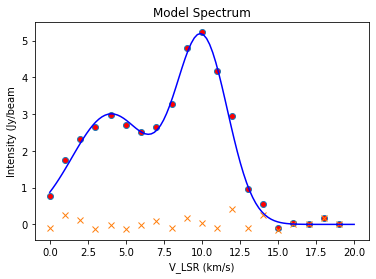

In [283]:
__plot(x, y, residual, x_smooth, model_smooth)

Perform the fit of two 1-d gaussians to the data

In [284]:
# params_0 are the initial guesses for the parameters, which would normally
# be provided by the user
# they are in the order [amp0, amp1, ..., ampN, center0, center1, ..., centerN,
# fwhm0, fwhm1, ..., fwhmN]
params_0 = [4.5, 2, 9, 5, 5, 7]
popt, perr = __fit(x, y, ngauss, params_0)

Summarize the fit

In [285]:
ndigits = 3
popt = popt.round(ndigits)
perr = perr.round(ndigits)
amp_fit = popt[0:ngauss]
center_fit = popt[ngauss:2*ngauss]
fwhm_fit = popt[2*ngauss:3*ngauss]
amp_err = perr[0:ngauss]
center_err = perr[ngauss:2*ngauss]
fwhm_err = perr[2*ngauss:3*ngauss]
for i in range(ngauss):
  print('Solution for gaussian {}:'.format(i))
  print('  Amplitude:', amp_fit[i], '+/-', amp_err[i])
  print('  Center:', center_fit[i], '+/-', center_err[i])
  print('  FWHM:', fwhm_fit[i], '+/-', fwhm_err[i])
  print()

g1d_fit = []
for i in range(ngauss):
  g1d_fit.append(fn.gaussian1d(amp_fit[i], center_fit[i], fwhm_fit[i]))

m = __model(x, g1d_fit)
rms_fit, chi2_fit = __rms_chisquare(y, m, noise)
print('rms of residuals of fit:', round(rms_fit, 3))
print(
    'Fit residuals have an rms that is {}% of the rms of the original residuals'
      .format(round(100*rms_fit/rms_orig, 3))
  )
print()
print('chi-square of fit:', round(chi2_fit, 3))

print(
  'Chi-square of fit is {}% chi-square of original'
    .format(round(100*chi2_fit/chi2_orig, 3))
  )

Solution for gaussian 0:
  Amplitude: 5.038 +/- 0.138
  Center: 10.007 +/- 0.081
  FWHM: 4.149 +/- 0.165

Solution for gaussian 1:
  Amplitude: 2.941 +/- 0.101
  Center: 3.863 +/- 0.17
  FWHM: 6.076 +/- 0.471

rms of residuals of fit: 0.138
Fit residuals have an rms that is 89.119% of the rms of the original residuals

chi-square of fit: 9.511
Chi-square of fit is 79.421% chi-square of original


Plot the data with the best fit model overlaid

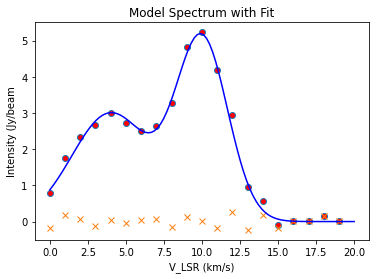

In [286]:
model_smooth = __model(x_smooth, g1d)
__plot(x, y, y-m, x_smooth, model_smooth, True)        

In [292]:
# create a model with 4 gaussians
# first, create an array of 4 1-d gaussian functionals
g1d, ngauss = __create_model(
    amplitude=[5, 3, 10, 7], center=[10, 4, 15, 20], fwhm=[4, 6, 6, 3]
  )
# then create data with noise
x, y, model, residual, x_smooth, model_smooth = __create_data(40, 0.2, g1d)

In [294]:
rms_orig, chi2_orig = __rms_chisquare(y, model, noise)
print('rms of residuals:', round(rms_orig, 3))
print('chi2:', round(chi2_orig, 3))

rms of residuals: 0.23
chi2: 52.738


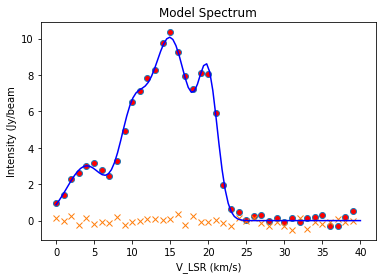

In [295]:
x_smooth = np.linspace(0, npixels, 100)
model_smooth = __model(x_smooth, g1d)
__plot(x, y, r, x_smooth, model_smooth)

In [296]:
# params_0 are the initial guesses for the parameters, which would normally
# be provided by the user
# they are in the order [amp0, amp1, ..., ampN, center0, center1, ..., centerN,
# fwhm0, fwhm1, ..., fwhmN]
params_0 = [4.5, 2, 9, 8, 9, 5, 13, 22, 5, 7, 7, 4]
popt, perr = __fit(x, y, ngauss, params_0)

In [297]:
ndigits = 3
popt = popt.round(ndigits)
perr = perr.round(ndigits)
amp_fit = popt[0:ngauss]
center_fit = popt[ngauss:2*ngauss]
fwhm_fit = popt[2*ngauss:3*ngauss]
amp_err = perr[0:ngauss]
center_err = perr[ngauss:2*ngauss]
fwhm_err = perr[2*ngauss:3*ngauss]
for i in range(ngauss):
  print(f'Solution for gaussian {i}:')
  print(f'  Amplitude: {amp_fit[i]} +/- {amp_err[i]}')
  print(f'  Center: {center_fit[i]} +/- {center_err[i]}')
  print(f'  FWHM: {fwhm_fit[i]} +/- {fwhm_err[i]}')
  print()

g1d_fit = []
for i in range(ngauss):
  g1d_fit.append(fn.gaussian1d(amp_fit[i], center_fit[i], fwhm_fit[i]))

m = __model(x, g1d_fit)
rms_fit, chi2_fit = __rms_chisquare(y, m, noise)
print('rms of residuals of fit:', round(rms_fit, 3))
print(
  'Fit residuals have an rms that is {}% of the rms of the original residuals'
    .format(round(100*rms_fit/rms_orig, 3))
  )
print()
print('chi-square of fit:', round(chi2_fit, 3))

print(
  'Chi-square of fit is {}% chi-square of original'
    .format(round(100*chi2_fit/chi2_orig, 3))
  )

Solution for gaussian 0:
  Amplitude: 4.493 +/- 1.048
  Center: 10.159 +/- 0.232
  FWHM: 3.606 +/- 0.535

Solution for gaussian 1:
  Amplitude: 3.094 +/- 0.139
  Center: 4.367 +/- 0.269
  FWHM: 6.505 +/- 0.706

Solution for gaussian 2:
  Amplitude: 10.159 +/- 0.164
  Center: 14.934 +/- 0.156
  FWHM: 6.094 +/- 0.813

Solution for gaussian 3:
  Amplitude: 6.749 +/- 0.649
  Center: 19.976 +/- 0.094
  FWHM: 3.084 +/- 0.207

rms of residuals of fit: 0.195
Fit residuals have an rms that is 85.058% of the rms of the original residuals

chi-square of fit: 38.155
Chi-square of fit is 72.349% chi-square of original


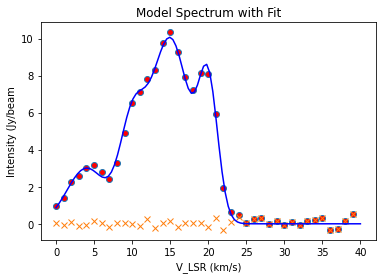

In [298]:
model_smooth = __model(x_smooth, g1d)
__plot(x, y, y-m, x_smooth, model_smooth, True)        